In [1]:
import math
from importlib import reload
import os

import gc
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm
from tqdm import trange

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint


from adaptive_time import mc2
import adaptive_time.utils
import gymnasium as gym
import random

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)



/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

## Data Generation

In [3]:

SHOULD_TERMINATE = True
discrete_reward = True
GRAB_DETAILED_DATA = False


In [4]:
seed = 13
dt_scaler = 20.
new_dt = 0.02 / dt_scaler
STEPS_MAX = 2000
STEPS_BREAK_FROM = 1200
# STEPS_BREAK_FROM = 900

# STEPS_MAX = 20_000
# STEPS_BREAK_FROM = 9_000

# NUM_TRAJS = 2
NUM_TRAJS = 100


In [5]:

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"


BASE_DIR = "classic_control_data"
data_descr = f"cartpole2_rew_{reward_type}_term{SHOULD_TERMINATE}"
traj_data_file = f"{data_descr}.pkl"



In [6]:
utils.set_directory_in_project()
# traj_data_path = os.path.join(BASE_DIR, traj_data_file)


Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [7]:

_NUM_ACTIONS = 2
START_STATE = (0.0, 0.0, 0.0, 0.0)

class TrajGen:

    def __init__(self, epsilon, detailed_data=False) -> None:
        self.env = gym.make(
            'CartPole-OURS-v2',
            discrete_reward=discrete_reward,
            should_terminate=SHOULD_TERMINATE,
            step_time=new_dt)

        self.phi = run_lib.make_features()
        self._epsilon = epsilon
        self._detailed_data = detailed_data

        utils.set_directory_in_project()
        self.weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
        # self.weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

    def policy(self, state, num_step, weights, epsilon):
        if num_step >= STEPS_BREAK_FROM:
            # if random.random() < 0.95:  # spread of 60 at 100 trajs
            if random.random() < 0.9:
            # if random.random() < 0.55:  # a nice spread
                return 0   # Alway push in one direction.

        if random.random() < epsilon:
            action = self.env.action_space.sample()
            return action
        
        # Otherwise calculate the best action.
        x = self.phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return np.argmax(qs)
        # return adaptive_time.utils.argmax(qs)
        
    def generate_trajectory(self, num_trajs):
        total_rewards = []
        reward_sequences = []
        traj_lengths = []
        angles = []
        xs = []
        d_angles = []
        actions = []
        dxs = []
        for idx in tqdm(range(num_trajs)):
            # Tuple[float, float, float, float]
            trajectory, early_term = value_est.generate_trajectory(
                    self.env, start_state=START_STATE,
                    policy=lambda st, sn: self.policy(st, sn, self.weights_good_policy, self._epsilon),
                    # policy=policy,
                    termination_prob=0.0, max_steps=STEPS_MAX)

            traj_lengths.append(len(trajectory))
            rewards = [r for _, _, r, _ in trajectory]
            if self._detailed_data:
                actions.append([a for _, a, _, _ in trajectory])
                xs.append([s[0] for s, _, _, _ in trajectory])
                angles.append([s[2] for s, _, _, _ in trajectory])
                d_angles.append([s[3] for s, _, _, _ in trajectory])
                dxs.append([s[1] for s, _, _, _ in trajectory])
            reward_sequences.append(rewards)
            total_rewards.append(sum(rewards))

        total_rewards = np.array(total_rewards)
        # Reward sequences may be different lengths in the terminating
        # case, so we can't make a 2D array.
        if not SHOULD_TERMINATE:
            reward_sequences = np.array(reward_sequences)
            traj_lengths = np.array(traj_lengths)
            angles = np.array(angles)
            xs = np.array(xs)
            d_angles = np.array(d_angles)
            actions = np.array(actions)
            dxs = np.array(dxs)

        if self._detailed_data:
            details = (angles, xs, d_angles, actions, dxs)
        else:
            details = None
        all_traj_data = (
            total_rewards, reward_sequences, traj_lengths,
            details
        )
        # with open(traj_data_path, "wb") as f:
        #     pickle.dump(all_traj_data, f)
        # print("Saved data to", traj_data_path)

        # print(self.env.tau)

        # print("total_rewards for each traj:", total_rewards)
        # if hasattr(reward_sequences, "shape"):
        #     print("all rewards shape if array:", reward_sequences.shape)
        # num_trajs = len(total_rewards)
        return all_traj_data

In [8]:
traj_gen = TrajGen(0.7, detailed_data=False)
run_lib.reset_randomness(seed, traj_gen.env)
all_traj_data = traj_gen.generate_trajectory(100)
total_rewards, reward_sequences, traj_lengths, details = all_traj_data

print(total_rewards)


Changed working directory to /Users/szepi1991/Code/adaptive_time


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


[1371. 1387. 1369. 1364. 1373. 1376. 1374. 1376. 1372. 1367. 1374. 1405.
 1382. 1365. 1373. 1394. 1370. 1365. 1376. 1374. 1367. 1374. 1382. 1374.
 1372. 1372. 1376. 1370. 1376. 1374. 1361. 1379. 1384. 1365. 1371. 1365.
 1373. 1374. 1378. 1369. 1367. 1368. 1370. 1368. 1372. 1396. 1365. 1374.
 1378. 1387. 1360. 1371. 1356. 1378. 1390. 1370. 1363. 1366. 1367. 1373.
 1367. 1365. 1372. 1368. 1370. 1351. 1373. 1376. 1379. 1365. 1382. 1373.
 1375. 1368. 1369. 1377. 1367. 1381. 1373. 1367. 1366. 1372. 1372. 1367.
 1367. 1388. 1361. 1375. 1372. 1372. 1373. 1370. 1366. 1369. 1383. 1370.
 1376. 1380. 1381. 1369.]


(array([ 2.,  3., 21., 28., 26., 12.,  4.,  2.,  1.,  1.]),
 array([1351. , 1356.4, 1361.8, 1367.2, 1372.6, 1378. , 1383.4, 1388.8,
        1394.2, 1399.6, 1405. ]),
 <BarContainer object of 10 artists>)

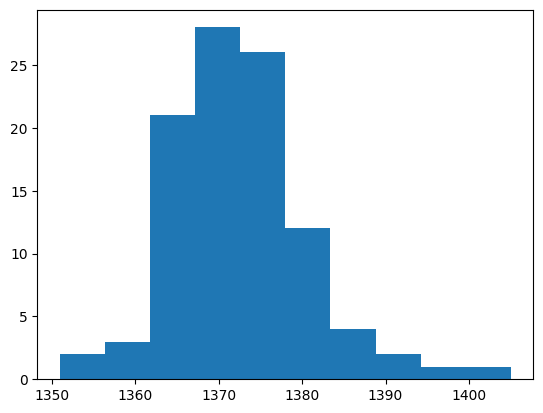

In [9]:
plt.hist(total_rewards)

## Data Processing

### Plot Styling

In [10]:
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("colorblind")


def set_size(width_pt, fraction=1, subplots=(1, 1), use_golden_ratio=True):
    """
    Reference: https://jwalton.info/Matplotlib-latex-PGF/
    Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    if use_golden_ratio:
        # Golden ratio to set aesthetic figure height
        golden_ratio = (5**0.5 - 1) / 2

        # Figure height in inches
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


### Data Parameters

In [11]:
def name_to_param(name):
    num = float(name[1:])
    if name[0] == 'q':
        return num
    else:
        return int(num)

def name_to_type(name):
    return name[0]

def param_to_name(sampler_char, param):
    return f"{sampler_char}{param}"

In [12]:
# unif_sampler_params = np.power(2, np.arange(0, 11, 2))
# quad_sampler_params = np.concatenate(
#     (np.array([0]), np.power(2, np.arange(-3.0, 10, 2))), axis=0
# )

unif_sampler_params = np.array([1, 1000])
quad_sampler_params = np.array([0.125, 100.0])

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)


unif_sampler_params: [   1 1000]
quad_sampler_params: [  0.125 100.   ]


In [13]:
samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


In [14]:
gc.collect()

# NUM_RUNS = 100
# SAMPLE_BUDGET = 1_000_000
NUM_RUNS = 8
SAMPLE_BUDGET = 10_005
seed = 43
EPSILON_IN_POLICY = 0.7

BUDGET_INTERP_STEP = 1_000

results_path = "results/cartpole_stoch_pol"

In [15]:
# # For testing
# def get_data_batch():
#     return total_rewards, reward_sequences

# Real.
traj_gen = TrajGen(EPSILON_IN_POLICY, detailed_data=False)
run_lib.reset_randomness(seed, traj_gen.env)

def get_data_batch(batch_size=1000):
    print("generating data batch...")
    all_traj_data = traj_gen.generate_trajectory(batch_size)
    total_rewards, reward_sequences, traj_lengths, details = all_traj_data
    return total_rewards, reward_sequences



Changed working directory to /Users/szepi1991/Code/adaptive_time


In [16]:

samplers_to_learn_with = samplers_tried
# samplers_to_learn_with = {
#     'u1024': samplers_tried['u1024'],
# }


### Learning Code

In [17]:


def process_batch_of_data(
        samplers_to_learn_with, update_budget,
        # Running estimates:
        return_estimates, samples_used_so_far,
        # Batch of new data:
        total_rewards, reward_sequences
    ):
    print("processing data batch...")
    # Each trajectory is transformed, by a sampler, into a pair:
    #   * return estimate
    #   * number of samples used.
    # We then just store these.
    more_to_do = False
    
    for sampler_name, sampler in samplers_to_learn_with.items():
        # print("sampler_name:", sampler_name)
        try:
            num_samples_at_start = samples_used_so_far[sampler_name][-1]
        except IndexError:
            num_samples_at_start = 0
        # print(num_samples_at_start)

        if num_samples_at_start >= update_budget:
            continue

        num_trajs = len(reward_sequences)
        cur_returns = np.zeros((num_trajs,))
        cur_num_samples = np.zeros((num_trajs,))
        for idx, reward_seq in enumerate(reward_sequences):
            integral, all_pivots = sampler.integrate(reward_seq)
            cur_returns[idx] = integral
            cur_num_samples[idx] = len(all_pivots)
        # print("AA:\n", cur_num_samples)
        new_total_samples = np.cumsum(cur_num_samples) + num_samples_at_start
        # print(new_total_samples)
        samples_used_so_far[sampler_name] = np.concatenate(
                    (samples_used_so_far[sampler_name], new_total_samples))
        return_estimates[sampler_name] = np.concatenate(
                    (return_estimates[sampler_name], cur_returns))

        used_samples = samples_used_so_far[sampler_name][-1]
        if used_samples < update_budget:
            more_to_do = True

    return more_to_do



def single_run(samplers_to_learn_with, get_data_batch):
    return_estimates = {}
    samples_used_so_far = {}
    for sampler_name in samplers_to_learn_with.keys():
        return_estimates[sampler_name] = np.array([])
        samples_used_so_far[sampler_name] = np.array([])

    all_updates = SAMPLE_BUDGET
    last_processed_so_far = 0
    with tqdm(total=all_updates) as progress_bar:
        more_to_do = True
        iter_num = 0
        true_returns = np.array([])
        while more_to_do and iter_num < SAMPLE_BUDGET:
            total_rewards, reward_sequences = get_data_batch()
            iter_num += 1
            true_returns = np.concatenate((true_returns, total_rewards))
            more_to_do = process_batch_of_data(
                    samplers_to_learn_with, SAMPLE_BUDGET,
                    # Running estimates:
                    return_estimates, samples_used_so_far,
                    # Batch of new data:
                    total_rewards, reward_sequences)
            
            # Just for updating the progress bar -- use the slowest of all samplers.
            processed_so_far = {k: samples_used_so_far[k][-1] for k in samplers_to_learn_with.keys()}
            total_processed_so_far = min(processed_so_far.values())
            progress_bar.update(total_processed_so_far - last_processed_so_far)
            last_processed_so_far = total_processed_so_far
            # print({k: samples_used_so_far[k][-1] for k in samplers_to_learn_with.keys()})

    # Turn the return estimates into value estimates.
    value_estimates = {
        sn: np.cumsum(return_estimates[sn]) / np.arange(1, len(return_estimates[sn]) + 1)
        for sn in samplers_to_learn_with.keys()
    }
    return value_estimates, samples_used_so_far, true_returns    




### Actual Learning

In [19]:

# Finally will have a `data` structure with:
# data[sampler_name][run_idx]{running_v_estimate or total_pivots}[idx_of_trajectory_processed]
# * We can actually keep around just the `returns_ests` instead of `running_v_estimate`
# * But it makes sense to have `total_pivots` since we want to check against the budget.

run_lib.reset_randomness(seed, env=None)   # TODO check about seeding...

data = {k: [] for k in samplers_to_learn_with.keys()}
true_returns = np.array([])
for i in trange(NUM_RUNS):
    print(f"\n====================== RUN {i} ======================\n\n")
    value_estimates, samples_used_so_far, true_returns = single_run(
        samplers_to_learn_with, get_data_batch)
    true_returns = np.concatenate((true_returns, total_rewards))    
    for sampler_name in samplers_to_learn_with.keys():
        data[sampler_name].append({
            "running_v_estimate": value_estimates[sampler_name],
            "total_pivots": samples_used_so_far[sampler_name],
        })


  0%|          | 0/8 [00:00<?, ?it/s]


====================== RUN 0 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:07<07:53, 67.61s/it]

processing data batch...

====================== RUN 1 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [02:11<06:33, 65.64s/it]

processing data batch...

====================== RUN 2 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [03:14<05:20, 64.16s/it]

processing data batch...

====================== RUN 3 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 4/8 [04:14<04:10, 62.51s/it]

processing data batch...

====================== RUN 4 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [05:15<03:06, 62.02s/it]

processing data batch...

====================== RUN 5 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [06:18<02:04, 62.35s/it]

processing data batch...

====================== RUN 6 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [07:21<01:02, 62.52s/it]

processing data batch...

====================== RUN 7 ======================




  0%|          | 0/10005 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

processing data batch...
generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 8/8 [08:21<00:00, 62.68s/it]

processing data batch...


In [20]:
true_return_est = np.sum(true_returns) / len(true_returns)
true_return_95conf = 1.96 * np.std(true_returns) / math.sqrt(len(true_returns))

print(f"true_return_est: {true_return_est}+-{true_return_95conf}")


true_return_est: 1371.240243902439+-0.6480360501259793


In [21]:
# Get more batches to get a good estimate of the true return.
for _ in tqdm(range(10)):
    total_rewards, reward_sequences = get_data_batch()
    true_returns = np.concatenate((true_returns, total_rewards))

true_return_est = np.sum(true_returns) / len(true_returns)
true_return_95conf = 1.96 * np.std(true_returns) / math.sqrt(len(true_returns))

print(f"true_return_est: {true_return_est}+-{true_return_95conf}")


  0%|          | 0/10 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

generating data batch...


  0%|          | 0/1000 [00:00<?, ?it/s]

true_return_est: 1371.058014184397+-0.3883721471043295


In [22]:
gc.collect()

34

In [23]:

# utils.set_directory_in_project("results/cartpole_stoch_pol")
# with open("second_data.pkl", "wb") as f:
#     pickle.dump({'data': data, 'true_returns': true_returns}, f)

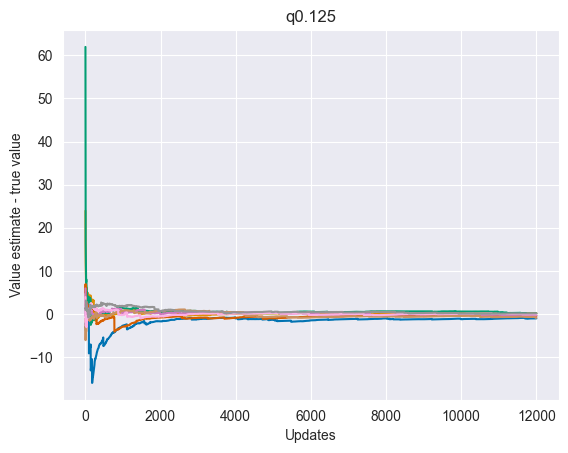

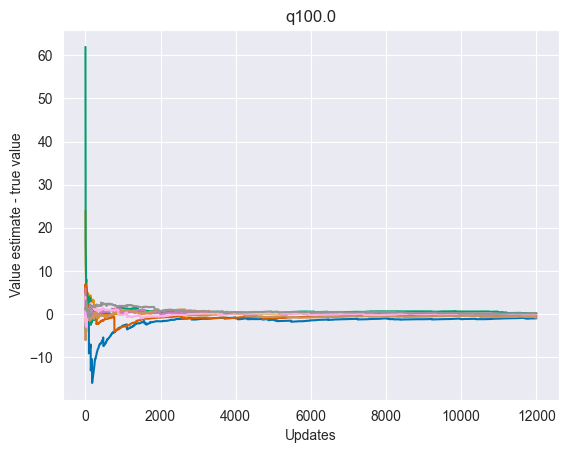

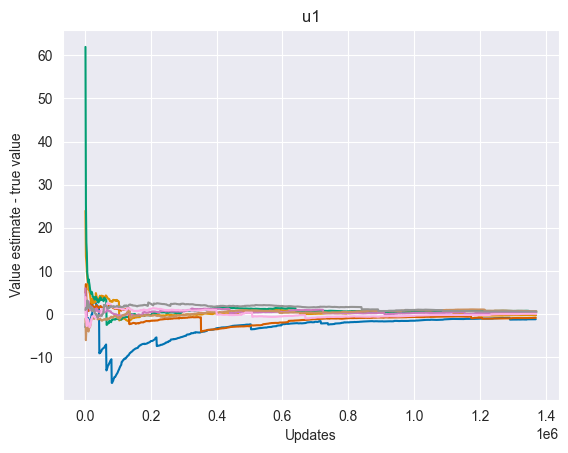

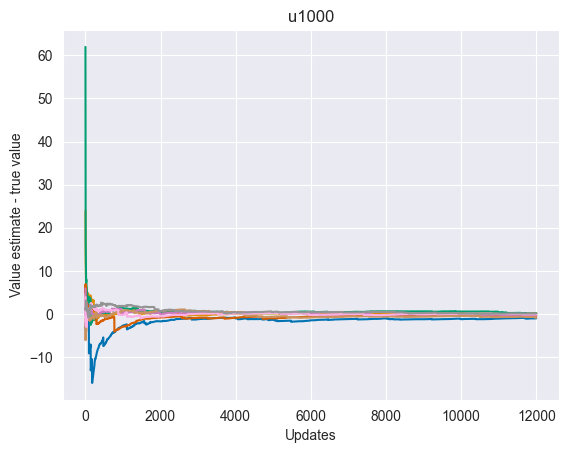

true_return_est: 1371.058014184397+-0.3883721471043295


In [24]:
for sampler_name in samplers_to_learn_with.keys():
    f = plt.figure()
        # data[sampler_name].append({
        #     "running_v_estimate": value_estimates[sampler_name],
        #     "total_pivots": samples_used_so_far[sampler_name],
        # })
    for run_data in data[sampler_name]:
        plt.plot(run_data["total_pivots"], run_data["running_v_estimate"] - true_return_est)
        plt.xlabel("Updates")
        plt.ylabel("Value estimate - true value")
    # plt.plot(samples_used_so_far[sampler_name], value_estimates[sampler_name]-true_return_est)
    plt.title(sampler_name)
    plt.show()

print(f"true_return_est: {true_return_est}+-{true_return_95conf}")


In [25]:
pprint([data['u1000'][r]['running_v_estimate'][-1] for r in range(NUM_RUNS)])
pprint([data['u1'][r]['running_v_estimate'][-1] for r in range(NUM_RUNS)])

[1370.04725,
 1371.2245,
 1371.19825,
 1370.59675,
 1370.718,
 1370.1945,
 1370.999,
 1371.204]
[1369.849, 1370.758, 1371.505, 1370.176, 1371.365, 1371.736, 1371.113, 1371.624]


In [26]:
pprint([data['u1000'][r]['total_pivots'][-1] for r in range(NUM_RUNS)])
pprint([data['u1'][r]['total_pivots'][-1] for r in range(NUM_RUNS)])

[11994.0, 11997.0, 11997.0, 11994.0, 11995.0, 11992.0, 11996.0, 11998.0]
[1369849.0,
 1370758.0,
 1371505.0,
 1370176.0,
 1371365.0,
 1371736.0,
 1371113.0,
 1371624.0]


In [27]:
pprint([data['q0.125'][r]['running_v_estimate'][-1] for r in range(NUM_RUNS)])
pprint([data['q100.0'][r]['running_v_estimate'][-1] for r in range(NUM_RUNS)])

[1370.04725,
 1371.2245,
 1371.19825,
 1370.59675,
 1370.718,
 1370.1945,
 1370.999,
 1371.204]
[1370.04725,
 1371.2245,
 1371.19825,
 1370.59675,
 1370.718,
 1370.1945,
 1370.999,
 1371.204]


In [28]:
pprint([data['q0.125'][r]['total_pivots'][-1] for r in range(NUM_RUNS)])
pprint([data['q100.0'][r]['total_pivots'][-1] for r in range(NUM_RUNS)])

[12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0]
[12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0, 12000.0]


In [29]:
list(data.values())[0][0].keys()

dict_keys(['running_v_estimate', 'total_pivots'])

In [30]:
_to_check = ["u256", "u1"]
# find the first in _to_check that is actually in the data.
setting_to_check = None
for setting in _to_check:
    if setting in data:
        setting_to_check = setting
        break

if setting_to_check is None:
    print("did not find any of these required settings, picking the first existing one")
    setting_to_check = list(data.keys())[0]

estimates_across_runs = np.array(
    [ data[setting_to_check][i]["running_v_estimate"][-10] for i in range(NUM_RUNS) ])
    # [ data[setting_to_check][i]["running_v_estimate"][-1000] for i in range(NUM_RUNS) ])
estimates_across_runs


array([1369.84258325, 1370.79616549, 1371.45206862, 1370.13118063,
       1371.32795156, 1371.73562059, 1371.09586276, 1371.64379415])

In [31]:
import copy
backup_data = copy.deepcopy(data)

In [32]:
# print(data.keys())
# data['q1.0'] = data['q1']
# del data['q1']
# print(data.keys())


In [33]:
gc.collect()

_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan, interp_step=BUDGET_INTERP_STEP, tqdm=tqdm)

gc.collect()

true_value = true_return_est
_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)


interpolating


  0%|          | 0/4 [00:00<?, ?it/s]

finding means and stderrs


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:70: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [34]:
error_data.means.keys()

dict_keys(['q0.125', 'q100.0', 'u1', 'u1000'])

## Plots

In [35]:
title = "Cartpole"
filename = data_descr

error_y_label = "$|v^\pi - \hat{v}|$"

utils.set_directory_in_project(results_path)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole_stoch_pol


'/Users/szepi1991/Code/adaptive_time/results/cartpole_stoch_pol'

In [36]:
axes_font_size = 11


Method: uniform


  0%|          | 0/2 [00:00<?, ?it/s]


Budget:  1000

Budget:  10000

Method: quadrature


  0%|          | 0/2 [00:00<?, ?it/s]


Budget:  1000

Budget:  10000


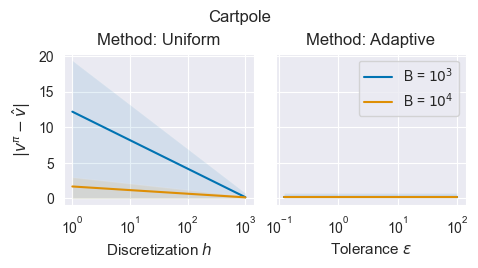

In [37]:


# These must be multiples of BUDGET_INTERP_STEP (usually 1000).
budgets_to_check = np.power(10, np.arange(3, 5, 1))
# budgets_to_check = np.power(10, np.arange(3, 7, 1))
if SAMPLE_BUDGET >= 2_000_000:
    budgets_to_check *= 2


# budgets_to_check = np.power(10, np.arange(2, 7, 1))

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

# fig, axes = plt.subplots(
#     nrows=1, ncols=2, figsize=(8, 4), layout="constrained", sharey=True)

doc_width_pt = 750.0
base_fig_size = set_size(doc_width_pt, 1.0, (1, 2))


fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(base_fig_size[0]*0.45, base_fig_size[1]*0.8),
    # figsize=set_size(doc_width_pt, 0.48, (1, 2)),
    layout="constrained", sharey=True)

# fig, axes = plt.subplots(
#     nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True)

# axes[0] will get the uniform results, axes[1] the quadrature results.

# Gather the data for the points on the x-axis.
all_methods = error_data.means.keys()
unif_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "u"}
quad_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "q"}

unif_xs = sorted(unif_methods.values())
quad_xs = sorted(quad_methods.values())

for ax_idx, ax, xs, method_char in zip(range(2), axes, (unif_xs, quad_xs), ("u", "q")):
    print()
    print("Method:", "uniform" if method_char == "u" else "quadrature")
    for budget_for_curve in tqdm(budgets_to_check):
        print()
        print("Budget: ", budget_for_curve)
        budget_idx = int(budget_for_curve / BUDGET_INTERP_STEP)
        y_means = []
        y_stderrs = []
        try:
            for x in xs:
                y_means.append(error_data.means[param_to_name(method_char, x)][budget_idx])
                y_stderrs.append(error_data.stderrs[param_to_name(method_char, x)][budget_idx])
                # y_means.append(np.nanmean(env_result[x][:, budget_idx]))
                # y_stderrs.append(np.nanstd(env_result[x][:, budget_idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            budget_exp = int(math.log10(budget_for_curve)) 
            ax.plot(
                xs,
                y_means,
                label=f"B = $10^{budget_exp}$" if ax_idx == 1 else ""
            )
            ax.fill_between(
                xs,
                0,
                # (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )

            # print("xs", xs)
            # print("y_means:", y_means)
            # print("y_stderrs:", y_stderrs)
        except IndexError:
            pass

    if method_char == "u":
        ax.set_ylabel(error_y_label, fontsize=axes_font_size)
        ax.set_xlabel("Discretization $h$", fontsize=axes_font_size)
        ax.set_title("Method: Uniform")
    else:
        ax.set_xlabel("Tolerance $\epsilon$", fontsize=axes_font_size)
        ax.set_title("Method: Adaptive")

    ax.set_xscale('log')
    # ax.set_yscale('log')
    if ax_idx == 1:
        ax.legend(title="Budget")

# plt.legend(title="Budget")
fig.suptitle(title)
plt.legend()

plt.savefig(f'{filename}_u_shaped2.pdf')
plt.savefig(f"{filename}_u_shaped2.png", dpi=600, format="pdf", bbox_inches="tight")

# def name_to_param(name):
#     return int(name[1:])

# def name_to_type(name):
#     return name[0]

# def param_to_name(param, sampler_char):
#     return f"{sampler_char}{param}"

